In [1]:
#!git clone https://github.com/elina22-hub/11785_SceneDetection_Quantization.git

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Cloning into '11785_SceneDetection_Quantization'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 257 (delta 47), reused 108 (delta 44), pack-reused 145
Receiving objects: 100% (257/257), 191.12 MiB | 55.08 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Checking out files: 100% (108/108), done.


In [3]:
#!pip install onnxruntime

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'


In [3]:
# copy data to 11785 directory
#%cp unique-142p.zip 11785_SceneDetection_Quantization/

cp: cannot stat 'unique-142p.zip': No such file or directory


In [1]:
# set current path to github model path
%cd ./11785_SceneDetection_Quantization

/home/ubuntu/11785_SceneDetection_Quantization


In [2]:
!unzip \*.zip

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Archive:  unique-142p.zip
   creating: unique-142p/
  inflating: unique-142p/frame_086825.png  
  inflating: unique-142p/frame_110853.png  
  inflating: unique-142p/frame_005292.png  
  inflating: unique-142p/frame_156806.png  
  inflating: unique-142p/frame_025142.png  
  inflating: unique-142p/frame_139219.png  
  inflating: unique-142p/frame_121456.png  
  inflating: unique-142p/frame_126339.png  
  inflating: unique-142p/frame_064678.png  
  inflating: unique-142p/frame_131645.png  
  inflating: unique-142p/frame_099905.png  
 extracting: unique-142p/frame_065566.png  
  inflating: unique-142p/frame_127027.png  
  inflating: unique-142p/frame_091381.png  
  inflating: unique-142p/frame_012936.png  
  inflating: unique-142p/fra

In [3]:
!cat /proc/cpuinfo

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) Platinum 8275CL CPU @ 3.00GHz
stepping	: 7
microcode	: 0x5003005
cpu MHz		: 1985.154
cache size	: 36608 KB
physical id	: 0
siblings	: 48
core id		: 0
cpu cores	: 24
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq monitor ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefe

In [4]:
# packages for Quantization
import os
import yaml
import onnx
import onnx.numpy_helper
import onnxruntime
import onnxruntime.quantization

# packages for loading the model
from model.beta_vae import *
import torch.utils.data 
from torchvision import datasets, transforms
import pdb
import torch.nn.functional as F
import torch
import numpy as np
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import shutil
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd

cuda = torch.cuda.is_available()
NUM_WORKERS = 4 if cuda else 0
DEVICE = torch.device("cuda" if cuda else "cpu")
BATCH_SIZE = 64
IMG_SIZE = 64

print(torch.__version__)
print(cuda)
print(NUM_WORKERS)
print(DEVICE)

1.8.1+cu111
False
0
cpu


In [5]:
# model hyperparameters (beta = 2)
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [6]:
config

{'model_params': {'name': 'BetaVAE',
  'beta': 2,
  'in_channels': 3,
  'latent_dim': 10,
  'loss_type': 'H',
  'max_capacity': 25,
  'Capacity_max_iter': 10000,
  'image_height': 64,
  'image_width': 64,
  'hidden_dims': [32, 64, 128, 256, 512]},
 'exp_params': {'img_size': 64,
  'train_data_dir': './data_train',
  'val_data_dir': './data_val',
  'model_save_dir': './best_model',
  'batch_size': 256,
  'learning_rate': 0.002,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.6,
  'max_epochs': 250,
  'manual_seed': 1265,
  'log_save_dir': './logs',
  'log_save_name': 'BetaVAE',
  'pic_save_dir': './scene_divergence_graph'}}

In [7]:
# load model
model = BetaVAE(**config['model_params'])
model_name = "Model_baseline"
model_path = "./best_model/" + model_name
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])
# make sure setting the model to eval mode before exporting to ONNX
model.eval()

BetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
  )
  (fc_mu): Linear(in_features=2048, out_features=10, bias=True)
  (fc_var): Linear(in_features=2048, out_features=10, bias=True)
  (decoder_input): Linear(in_features=10, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_paddin

### Data Processing (Run Only Once Unless Terminal Crash)

Notice: Unique images index is not continuous. Also, .DS_Store is in the imagefile, remove it

In [8]:
%pwd

'/home/ubuntu/11785_SceneDetection_Quantization'

In [9]:
# pick the validation set from unique 142p dataset
imagefile = os.listdir("unique-142p")
imageset = set(imagefile)
old_path = "./unique-142p"
new_path = "./unique-142p-valid/142p-image/"
data_dir = "./unique-142p-valid/"

In [10]:
# pick validation images
def get_valid_image_list(imagefile):
    """
    input: imagefile -> the unique-142p file
    return: valid_image_list -> image name list for validation
    """
    valid_image_list = []
    st_idx = 1
    ed_idx = 25947
    for image in imagefile:
        if image != ".DS_Store":
            idx = int(image[6:12])
            if st_idx <= idx <= ed_idx:
                valid_image_list.append(image)
    return valid_image_list

In [11]:
# create file and put it under another file name
def copy_valid_image(valid_image_list, old_path, new_path):
    # determine whether new path exists
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for valid_image in valid_image_list:
        shutil.copyfile(os.path.join(old_path, valid_image), os.path.join(new_path, valid_image))

In [12]:
# get validation image list and put it under the corresponding directory
valid_image_list = get_valid_image_list(imagefile)
copy_valid_image(valid_image_list, old_path, new_path)

In [13]:
# create subfolder for each images in the folder, with name of the subfolder being the int(image[6:12]) name
def create_imagefolder(valid_image_list, image_path):
    for image in os.listdir(image_path):
        os.makedirs(os.path.join(image_path, "folder_"+image))
    # put each image into the subfolder
    for valid_image in valid_image_list:
        shutil.move(os.path.join(image_path, valid_image), os.path.join(image_path, "folder_"+valid_image))

In [14]:
# create subfolder for each images in the folder, with name of the subfolder being the int(image[6:12]) name
create_imagefolder(valid_image_list, new_path)

In [15]:
%mkdir unique-142p-valid-backup

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'


In [16]:
%cd unique-142p-valid/142p-image/

/home/ubuntu/11785_SceneDetection_Quantization/unique-142p-valid/142p-image


In [17]:
# create reference index
ref_image_folder_indices = os.listdir()
ref_image_folder_indices.sort()
print(ref_image_folder_indices[:10])

['folder_frame_000001.png', 'folder_frame_000012.png', 'folder_frame_000015.png', 'folder_frame_000016.png', 'folder_frame_000017.png', 'folder_frame_000018.png', 'folder_frame_000020.png', 'folder_frame_000021.png', 'folder_frame_000022.png', 'folder_frame_000023.png']


In [19]:
%cd ..

/home/ubuntu/11785_SceneDetection_Quantization


### DataLoader

In [20]:
def load_data(phase, data_dir):
    transform_list = data_transforms(phase)
    if phase == "train":
        dataset = datasets.ImageFolder(data_dir, transform=transform_list)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
    else:
        dataset = datasets.ImageFolder(data_dir, transform=transform_list)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=NUM_WORKERS)
    return dataset, data_loader
        
def data_transforms(phase):
    if phase == "train":
        transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8),
                                        transforms.ToTensor()])
    else:
        transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()])
    return transform

In [21]:
# create validation dataloader
valid_dataset, valid_dataloader = load_data(phase="eval", data_dir=data_dir)
example_valid_input = next(iter(valid_dataloader))[0]
print("\nDetails of the validation dataset and data loader are below.\n")
print("Num Observations: {}\nNum Batches:\t  {}\nBatch Shape:\t  {}\nNum Classes:\t  {}".\
      format(len(valid_dataset), len(valid_dataloader), list(example_valid_input.shape), len(valid_dataset.classes)))


Details of the validation dataset and data loader are below.

Num Observations: 14196
Num Batches:	  221
Batch Shape:	  [64, 3, 64, 64]
Num Classes:	  1


In [22]:
# create dictionary for matching
batch_idx = [i for i in range(BATCH_SIZE * len(valid_dataloader))]
batch_to_image = dict(zip(batch_idx, ref_image_folder_indices))

### Convert Pytorch model to ONNX model

In [23]:
# model path
onnx_model_file = "./onnx_model/"

In [24]:
if not os.path.exists(onnx_model_file):
    os.mkdir(onnx_model_file)

In [25]:
# convert pytorch model to ONNX model
onnx_model_path = onnx_model_file + model_name + ".onnx"     # float 32
qi_onnx_model_path = onnx_model_file + "QI-" + model_name + ".onnx"  # int 8
print(onnx_model_path)
print(qi_onnx_model_path)

./onnx_model/Model_baseline.onnx
./onnx_model/QI-Model_baseline.onnx


In [26]:
# input to the model (same shape as batch input shape), just put some random input in
x = torch.ones(64, 3, 64, 64)
# Export pytorch model as onnx model
torch.onnx.export(model, x, onnx_model_path, input_names=["input"], output_names=["output"], opset_version=11)

In [25]:
#!pip install --upgrade onnx

In [27]:
# load onnx model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

### Quantize Float32 Model to Int8 Model

In [28]:
# per channel=True???
kwargs = {"op_types_to_quantize":     [],
          "per_channel":              True,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_dynamic(onnx_model_path, qi_onnx_model_path, **kwargs)

In [29]:
# Compare model parameters size
onnx_size_mb   = os.path.getsize(onnx_model_path)/1e6
qi_onnx_size_mb = os.path.getsize(qi_onnx_model_path)/1e6

print("\nONNX model size (MB):     {:.2f}".format(onnx_size_mb))
print("\nQI-ONNX model size (MB):  {:.2f}".format(qi_onnx_size_mb))


ONNX model size (MB):     12.84

QI-ONNX model size (MB):  7.96


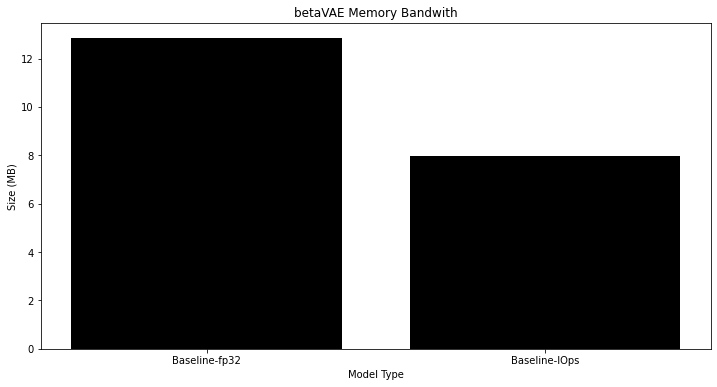

In [32]:
x = [onnx_size_mb, qi_onnx_size_mb]
y = ['Baseline-fp32','Baseline-IOps']
title = "betaVAE Memory Bandwith"
x_label = "Model Type"
y_label = "Size (MB)"
plot_statistic(x, y, title, x_label, y_label)

In [21]:
torch.tensor(np.array([1,2,3]))

tensor([1, 2, 3])

### Perform Inference on Input Images

In [31]:
class init_inference:
    def __init__(self, session):
        self.session = session
        
    def __call__(self, image):
        input_data = image.numpy()
        input_name  = self.session.get_inputs()[0].name
    
        return self.session.run(None, {input_name: input_data})

def mean_latency_fn(tqdm_dataloader):
    start = tqdm_dataloader.start_t
    stop = tqdm_dataloader.last_print_t
    n = tqdm_dataloader.n
    mean_latency = (stop - start)/n
    return mean_latency

def simple_table(data_multilist, x_label_list, y_label_list):
    for i in range(len(y_label_list)+1):
        if i == 0:
            row = ["\t"]
            row.extend(x_label_list)
            string = "\t".join(row)
        else:
            row = [y_label_list[i-1]]
            
            row.extend([format(x, ".6f") for x in data_multilist[i-1]])
            string = "\t".join(row)
            
        print(string)
        
    return None

def plot_statistic(x, y, title, x_label, y_label):

    label_pos = [i for i, _ in enumerate(x)]

    plt.figure(figsize=(12, 6))
    plt.bar(label_pos, x, color='black', width=0.8)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(label_pos, y)
    
    plt.show()
    
    return None

def valid_model(valid_dataloader, session):
    tqdm_dataloader = tqdm(valid_dataloader)
    inference = init_inference(session)
    valid_loss = {'val_total_loss':0.0, 'val_recon_loss':0.0,'val_kld':0.0}
    len_data_loader = len(valid_dataloader)
    
    # Latent Space
    mu = None
    logvar = None
    
    # origin_images
    origin_images_list = []
    index_list = []
    
    for _, (images, y) in enumerate(tqdm_dataloader):
        results = inference(images)
        # covert results into tensor
        results_converted = []
        for result in results:
            result = torch.tensor(result)
            results_converted.append(result)
        
        # Latent Space
        latent_u = results_converted[2]
        latent_logvar = results_converted[3]
        
        loss = model.loss_function(*results_converted,M_N = 1.0/float(len_data_loader), batch_size=BATCH_SIZE)
        
        valid_loss['val_total_loss'] += loss['total_loss'].cpu().detach().numpy()
        valid_loss['val_recon_loss'] += loss['recon_loss'].cpu().detach().numpy()
        valid_loss['val_kld'] += loss['kld'].cpu().detach().numpy()
        
        # Latent Space
        if mu == None and logvar == None:
            mu = latent_u
            logvar = latent_logvar
        else:
            mu = torch.cat((mu, latent_u))
            logvar = torch.cat((logvar, latent_logvar))
            
        # origin_images
        origin_images_list.append(images)
        index_list.append(y)
            
    valid_loss['val_total_loss'] /= len_data_loader
    valid_loss['val_recon_loss'] /= len_data_loader
    valid_loss['val_kld'] /= len_data_loader
    mean_latency = mean_latency_fn(tqdm_dataloader)

    origin_images_tensor = torch.cat(origin_images_list, dim=0)
    index_tensor = torch.cat(index_list, dim=0)
    
    return valid_loss, mean_latency, origin_images_tensor, index_tensor, mu.cpu().detach().numpy(), logvar.cpu().detach().numpy()

In [59]:
def valid_model_only(valid_dataloader, session):
    tqdm_dataloader = tqdm(valid_dataloader)
    inference = init_inference(session)
    len_data_loader = len(valid_dataloader) 
    for _, (images, y) in enumerate(tqdm_dataloader):
        results = inference(images)
    mean_latency = mean_latency_fn(tqdm_dataloader)
    return mean_latency

In [60]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)
mean_latency = valid_model_only(valid_dataloader, ort_session)

  0%|          | 0/221 [00:00<?, ?it/s]

In [ ]:
loss, mean_latency, origin_images_tensor, index_tensor, mu, logvar = valid_model(valid_dataloader, ort_session)

In [34]:
print("Basline Model Loss (Float 32): ")
print(loss)

Basline Model Loss (Float 32): 
{'val_total_loss': 185.85378301629115, 'val_recon_loss': 140.6518015020034, 'val_kld': 22.6009912318234}


In [61]:
qi_ort_session = onnxruntime.InferenceSession(qi_onnx_model_path)
qi_mean_latency = valid_model_only(valid_dataloader, qi_ort_session)

  0%|          | 0/221 [00:00<?, ?it/s]

In [ ]:
qi_loss, qi_mean_latency, qi_origin_images_tensor, qi_index_tensor, qi_mu, qi_logvar = valid_model(valid_dataloader, qi_ort_session)

In [36]:
print("Quantized Basline Model Loss (Int 8): ")
print(qi_loss)

Quantized Basline Model Loss (Int 8): 
{'val_total_loss': 187.25416570982782, 'val_recon_loss': 141.95602146856385, 'val_kld': 22.649072112001445}


In [62]:
print('Total mean latency (float32): {}'.format(mean_latency))
print('Total mean latency (int8): {}'.format(qi_mean_latency))

Total mean latency (float32): 0.13840156874505644
Total mean latency (int8): 0.1769877440249758


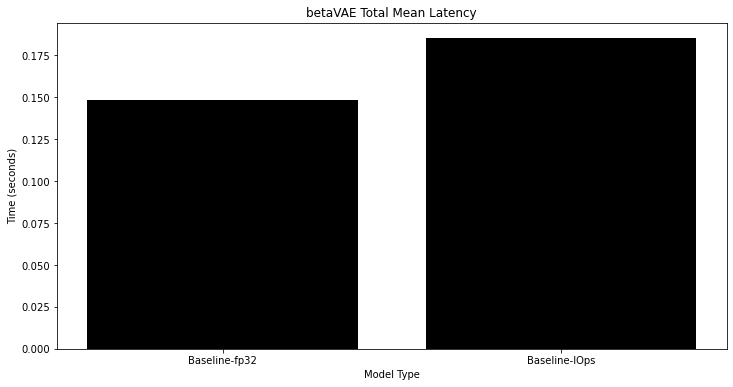

In [38]:
x = [mean_latency, qi_mean_latency]
y = ['Baseline-fp32','Baseline-IOps']
title = "betaVAE Total Mean Latency"
x_label = "Model Type"
y_label = "Time (seconds)"
plot_statistic(x, y, title, x_label, y_label)

## Export Encoder to ONNX

In [39]:
# convert pytorch model to ONNX model
onnx_encoder_path = onnx_model_file + model_name + "_encoder"+".onnx"     # float 32
qi_onnx_encoder_path = onnx_model_file + "QI-" + model_name + "_encoder"+".onnx"  # int 8
print(onnx_encoder_path)
print(qi_onnx_encoder_path)

./onnx_model/Model_baseline_encoder.onnx
./onnx_model/QI-Model_baseline_encoder.onnx


In [40]:
# input to the model (same shape as batch input shape), just put some random input in
x = torch.ones(64, 3, 64, 64)
# Export pytorch model as onnx model
torch.onnx.export(model.encoder, x, onnx_encoder_path, input_names=["input"], output_names=["output"], opset_version=11)

In [41]:
# load onnx model
onnx_encoder = onnx.load(onnx_encoder_path)
onnx.checker.check_model(onnx_encoder)

In [42]:
onnxruntime.quantization.quantize_dynamic(onnx_encoder_path, qi_onnx_encoder_path, **kwargs)

In [43]:
# Compare model parameters size
onnx_encoder_size_mb = os.path.getsize(onnx_encoder_path)/1e6
qi_onnx_encoder_size_mb = os.path.getsize(qi_onnx_encoder_path)/1e6
print("\nONNX encoder size (MB):     {:.2f}".format(onnx_encoder_size_mb))
print("\nQI-ONNX encoder size (MB):  {:.2f}".format(qi_onnx_encoder_size_mb))


ONNX encoder size (MB):     6.28

QI-ONNX encoder size (MB):  1.58


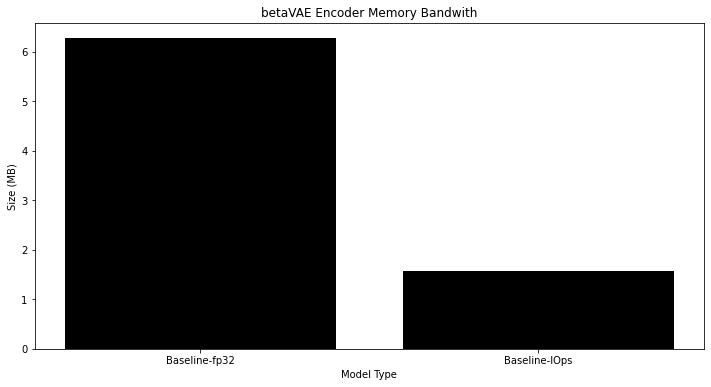

In [44]:
x = [onnx_encoder_size_mb, qi_onnx_encoder_size_mb]
y = ['Baseline-fp32','Baseline-IOps']
title = "betaVAE Encoder Memory Bandwith"
x_label = "Model Type"
y_label = "Size (MB)"
plot_statistic(x, y, title, x_label, y_label)

In [45]:
def valid_encoder(valid_dataloader, session):
    tqdm_dataloader = tqdm(valid_dataloader)
    inference = init_inference(session)
    len_data_loader = len(valid_dataloader) 
    for _, (images, y) in enumerate(tqdm_dataloader):
        results = inference(images)
    mean_latency = mean_latency_fn(tqdm_dataloader)
    return mean_latency

In [46]:
ort_session = onnxruntime.InferenceSession(onnx_encoder_path)
float_mean_latency = valid_encoder(valid_dataloader, ort_session)

  0%|          | 0/221 [00:00<?, ?it/s]

In [47]:
qi_ort_session = onnxruntime.InferenceSession(qi_onnx_encoder_path)
int_mean_latency = valid_encoder(valid_dataloader, qi_ort_session)

  0%|          | 0/221 [00:00<?, ?it/s]

In [48]:
print('encoder mean_latency (float32): {}'.format(float_mean_latency))
print('encoder mean_latency (int8): {}'.format(int_mean_latency))

encoder mean_latency (float32): 0.0651854001558744
encoder mean_latency (int8): 0.09125997793620529


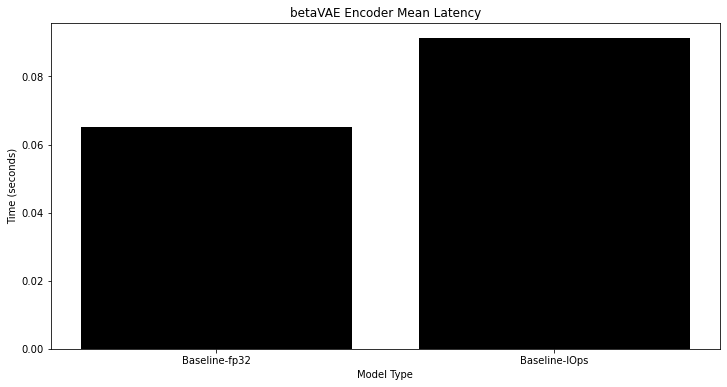

In [49]:
x = [float_mean_latency, int_mean_latency]
y = ['Baseline-fp32','Baseline-IOps']
title = "betaVAE Encoder Mean Latency"
x_label = "Model Type"
y_label = "Time (seconds)"
plot_statistic(x, y, title, x_label, y_label)

In [63]:
print('decoder mean_latency (float32): {}'.format(mean_latency - float_mean_latency))
print('decoder mean_latency (int8): {}'.format(qi_mean_latency - int_mean_latency))

decoder mean_latency (float32): 0.07321616858918203
decoder mean_latency (int8): 0.08572776608877052


### Compare Accuracy of the scene change (Float 32 vs Int 8)

In [50]:
def KL_latent(mu1, logvar1, mu2, logvar2):
    latent_dim = mu1.shape[0]
    sigma1 = np.exp(0.5*logvar1)
    sigma2 = np.exp(0.5*logvar2)
    KL = 0.5*((sigma1 / sigma2).sum() + ((mu2 - mu1) * (mu2 - mu1) / sigma2).sum() - latent_dim + np.log(sigma2.prod() / sigma1.prod()))
    return KL

In [51]:
def compute_frame_KL_div(mu, logvar):
    """
    mu: 
    logvar:
    return: 
    """
    assert mu.shape[0] == logvar.shape[0]
    kl_div_list = []
    n = mu.shape[0]
    # O(N) complexity
    for i in range(1, n):
        kl_div = KL_latent(mu[i-1], logvar[i-1], mu[i], logvar[i])
        kl_div_list.append(kl_div)
    return np.array(kl_div_list)

In [52]:
def topK_KLdiv_search(kl_div_list, K=259):
    """
    kl_div_list:
    return: 
    """
    assert K >= 259
    assert len(kl_div_list) > K
    scene_change_pairs = []
    Kmax_index = kl_div_list.argsort()[-K:][::-1]
    for pair in zip(Kmax_index, Kmax_index + 1):
        scene_change_pairs.append(pair)
    return scene_change_pairs

In [53]:
def pair2image(scene_change_pairs, batch_to_image):
    """
    scene_change_pairs:
    batch_to_image: dict
    return:
    """
    scene_change_list = []
    for pair in scene_change_pairs:
        frame1 = batch_to_image[pair[0]]
        frame2 = batch_to_image[pair[1]]
        scene_change_list.append((frame1[7:], frame2[7:]))
    return scene_change_list

In [54]:
# compare predict dataframe with label dataframe
def scene_change_detect_accuracy(scene_change_labels, predict_scene_change_df):
    count = 0
    total = len(scene_change_labels)
    for i in range(len(scene_change_labels)):
        pred_frame1 = predict_scene_change_df.iloc[i]['frame1']
        pred_frame2 = predict_scene_change_df.iloc[i]['frame2']
        true_frame1_series = scene_change_labels['frame1']
        if pred_frame1 in true_frame1_series.values:
            # find corresponding index of this predict frame1 in the groud_truth df
            idx = true_frame1_series[true_frame1_series == pred_frame1].index[0]
            # compare pred_frame2 and groud truth frame2 is the same
            true_frame2 = scene_change_labels.iloc[idx]['frame2']
            if pred_frame2 == true_frame2:
                count += 1
    acc = count / total
    return acc, count

In [55]:
# read scene-change.csv
scene_change_labels = pd.read_csv("scene-change.csv")

**Float 32 Model**

In [56]:
# compute kl_divergence
kl_div_list = compute_frame_KL_div(mu, logvar)
scene_change_pairs = topK_KLdiv_search(kl_div_list)
scene_change_pairs_imagename = pair2image(scene_change_pairs, batch_to_image)

# Create Dataframe
predict_scene_change_df = pd.DataFrame(scene_change_pairs_imagename, columns=["frame1", "frame2"])
predict_scene_change_df = predict_scene_change_df.sort_values(by=['frame1']).reset_index(drop=True)

# Compute Scene change accuracy
acc, count = scene_change_detect_accuracy(scene_change_labels, predict_scene_change_df)
print("Accuracy of Float-32 Model is: {:,.2f}%".format(acc*100))
print("Correctly Identified Scene-Change: ",count)

Accuracy of Float-32 Model is: 84.17%
Correctly Identified Scene-Change:  218


**Int 8 Model**

In [57]:
# compute kl_divergence
qi_kl_div_list = compute_frame_KL_div(qi_mu, qi_logvar)
qi_scene_change_pairs = topK_KLdiv_search(qi_kl_div_list)
qi_scene_change_pairs_imagename = pair2image(qi_scene_change_pairs, batch_to_image)

# Create Dataframe
qi_predict_scene_change_df = pd.DataFrame(qi_scene_change_pairs_imagename, columns=["frame1", "frame2"])
qi_predict_scene_change_df = qi_predict_scene_change_df.sort_values(by=['frame1']).reset_index(drop=True)

# Compute Scene change accuracy
qi_acc, qi_count = scene_change_detect_accuracy(scene_change_labels, qi_predict_scene_change_df)
print("Accuracy of Int-8 Model is: {:,.2f}%".format(qi_acc*100))
print("Correctly Identified Scene-Change: ",qi_count)

Accuracy of Int-8 Model is: 84.94%
Correctly Identified Scene-Change:  220


## Visualize latent space using t-SNE 

In [64]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [65]:
import seaborn as sns

In [66]:
feat_cols = ['latent_dim'+str(i) for i in range(mu.shape[1])]
feat_cols

['latent_dim0',
 'latent_dim1',
 'latent_dim2',
 'latent_dim3',
 'latent_dim4',
 'latent_dim5',
 'latent_dim6',
 'latent_dim7',
 'latent_dim8',
 'latent_dim9']

In [67]:
df = pd.DataFrame(mu, columns=feat_cols)
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (14144, 10)


In [68]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

print(pca_result[:10,])

[[-0.07735091  0.00660843  0.26789033]
 [-0.02371402  0.04883613  0.30839276]
 [ 0.02301948  0.08034872  0.31014338]
 [ 0.04675051  0.11019692  0.33339068]
 [-0.03004789  0.289853    0.28094342]
 [-0.1236878   0.4450546   0.2451933 ]
 [-0.24707009  0.6379181   0.27564314]
 [-0.41620833  0.91453415  0.34704542]
 [-0.5376006   1.1400588   0.4411112 ]
 [-0.70101386  1.4250095   0.45667243]]


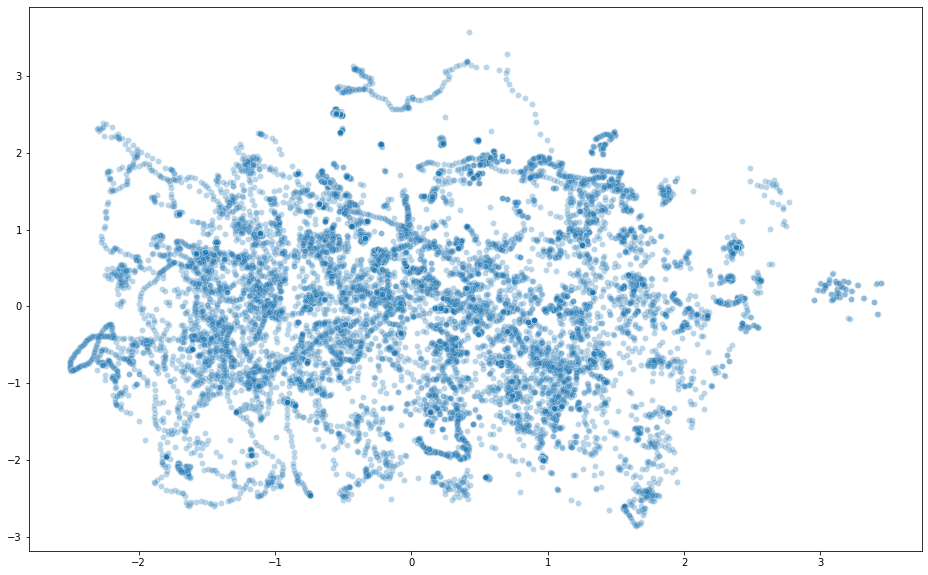

In [69]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    #hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)
plt.show()

In [70]:
mu_embeded = TSNE(n_components=2).fit_transform(mu)

In [72]:
mu_embeded.shape

(14144, 2)

In [139]:
def create_mu_label(batch_to_image, scene_change_labels):
    true_frame1_series = scene_change_labels['frame1']
    mu_label = []
    max_len = len(true_frame1_series)
    true_id = 0
    for img in batch_to_image.values():
        if true_id < max_len and img == 'folder_'+ true_frame1_series[true_id]:
            true_id += 1
        mu_label.append(str(true_id))
    return mu_label

In [132]:
updated_scene_change_labels = pd.read_csv('updated_scene-change.csv')

In [140]:
mu_label = create_mu_label(batch_to_image, updated_scene_change_labels)

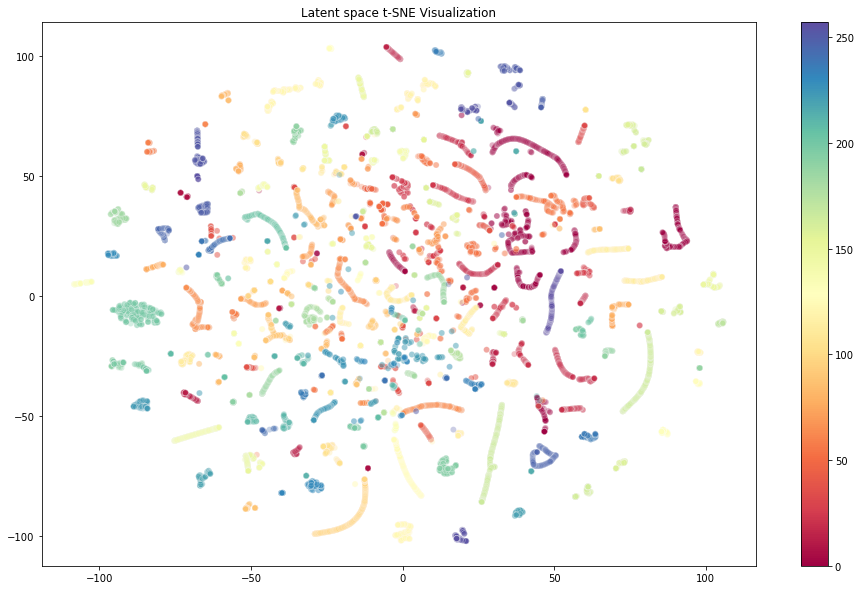

In [159]:
tsne_2d_one = mu_embeded[:,0]
tsne_2d_two = mu_embeded[:,1]

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_2d_one, y=tsne_2d_two,
    hue=mu_label,
    palette="RdBu",
    data=mu,
    legend=False,
    alpha=0.3)
norm = plt.Normalize(0, 257)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.title('Latent space t-SNE Visualization')
plt.show()